# GWs from a given black-hole

In [1]:
%pylab inline
import gwaxion

Populating the interactive namespace from numpy and matplotlib


Assuming we do not know whether a boson exists and what mass it may have, we can ask about the possible boson GW signals that could be expected from a boson cloud around a given black hole (BH).

Imagine we are targeting a specific hole with initial known mass ($60 M_\odot$) and spin (0.7), at a distance of 5 Mpc:

In [2]:
bh = gwaxion.BlackHole(mass=60, chi=0.7, msun=True)
distance = 5E6 * gwaxion.PC_SI

Let's ask about the possible strains $h_0$ that are possible assuming an $\ell = m =1$ cloud around this BH, made up of a boson of unknown mass. As we vary the boson mass, the resulting GWs will have a different frequency, so we can plot $h_0$ vs $f_{\rm GW}$.

We will compute this in a couple of different ways using `gwaxion`.

## 22 vs 32

We will do this for both the dominant $(\tilde{\ell}=2,\, \tilde{m}=2)$ mode of the strain, as well as the subdominant $(\tilde{\ell}=3,\, \tilde{m}=2)$.

In [3]:
# create an array of GW frequencies
fgws = arange(10, 300, 1)

# obtain the expected strain amplitude as a function of frequency, which
# is computed internally by interpolating for different boson masses
# (this may take long, but the result is cached)
h0_lgw2 = bh.h0r_fit(fgws)/distance
h0_lgw3 = bh.h0r_fit(fgws, lgw=3)/distance

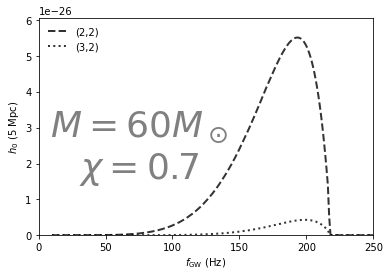

In [4]:
# plot it
plot(fgws, h0_lgw2, label='(2,2)', lw=2, alpha=0.8, c='k', ls='--')
plot(fgws, h0_lgw3, label='(3,2)', lw=2, alpha=0.8, c='k', ls=':')

xlim(0, 250);
ylim(0, max(h0_lgw2)*1.1);
xlabel(r'$f_{\rm GW}$ (Hz)');
ylabel(r'$h_0$ (5 Mpc)');

annotate(r'$M=60 M_\odot$'+'\n'+r'$\chi=0.7$', xy=(0.3, 0.4), xycoords="axes fraction", 
            ha='center', va='center', fontsize=36, color='gray')

legend(loc='best', frameon=False)

We can also look at the aplitude ratio between the two modes as a function of frequency:

/Users/richardbrito/opt/anaconda3/envs/gwaxion/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


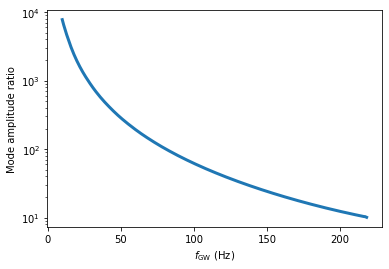

In [5]:
semilogy(fgws, h0_lgw2/h0_lgw3, lw=3)
xlabel(r"$f_{\rm GW}$ (Hz)");
ylabel('Mode amplitude ratio');

## Analytic approximations

The above result made use of numerical results for the GW emission from [arXiv:1706.06311](https://arxiv.org/abs/1706.06311), we can compare against different approximations. This time, we will use `multiprocessing` to speed things up.

To use `multiprocessing` we need top-level-defined functions, which we will used instead of the functions already defined in the `gwaxion.physics` module.

In [6]:
def get_peak(a, lgw=2, **kwargs): 
    cloud = gwaxion.BosonCloud.from_parameters(1, 1, 0, alpha=a, evolve_params={'y_0': 1E-8}, **kwargs) 
    return cloud.gw(lgw).h0r, cloud.gw(lgw).f

Now, we can use this to more quickly compute the strain amplitude $h_0$ for different values of $\alpha$ (which will give the same result as above).

In [7]:
import multiprocessing
from functools import partial

alphas = np.arange(0.01, 0.25, 0.001)

# collect peak values
pool = multiprocessing.Pool(8)
h0r_fs = pool.map(partial(get_peak, m_bh=bh.mass_msun, chi_bh=bh.chi), alphas)
h0rs_num, fgws_num = np.array(h0r_fs).T

# h0rs are the amplitudes 1m away from the source, so rescale by actual distance
h0s_num = h0rs_num / distance

Let's get the properties of the system for the boson (i.e. $\alpha$) best matching our BH:

In [8]:
best = max(zip(h0r_fs, alphas))
print("Best boson for this BH:\n-----------------------")
print("h0\t%.1e" % best[0][0])
print("fgw\t%.1f Hz" % best[0][1])
print("alpha\t%.3f" % best[1])

print("\nPost-SR BH properties\n---------------------")
bhb = gwaxion.BlackHoleBoson.from_parameters(m_bh=bh.mass_msun, chi_bh=bh.chi, alpha=best[1])
c = bhb.cloud(1, 1, 0)
l = [
    'Boson mass: %.1e eV' % c.bhb_final.boson.energy_ev,
    'Final alpha: %.3f' % c.bhb_final.alpha,
    'Final BH mass: %.2f Msun' % c.bhb_final.bh.mass_msun,
    'Final BH spin: %.3f' % c.bhb_final.bh.chi,
    'Fractional BH mass lost: %.3f' % (c.mass_msun/c.bhb_initial.bh.mass_msun),
]
print('\n'.join(l))

Best boson for this BH:
-----------------------
h0	8.5e-03
fgw	193.0 Hz
alpha	0.180

Post-SR BH properties
---------------------
Boson mass: 4.0e-13 eV
Final alpha: 0.177
Final BH mass: 59.02 Msun
Final BH spin: 0.629
Fractional BH mass lost: 0.016


Let's compare the above results, computed by numerically solving the cloud evolution DEs, to those approximating the final mass by the initial mass for part of the calculation:

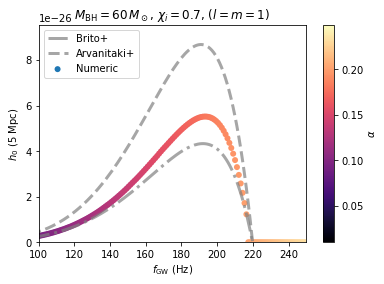

In [9]:
# Brito+ approximation
h0s_2, fgws_2 = gwaxion.h0_scalar_brito(bh.mass_msun, alphas, chi_i=bh.chi, d=distance)

# Arvanitaki+ approximation
h0s_3, fgws_3 = gwaxion.h0_scalar_approx(alphas, m_bh=bh.mass_msun, d=distance, chi=bh.chi)
h0s_3 *= np.sqrt(2*np.pi)

cmap = 'magma'
s = scatter(fgws_num, h0s_num, c=alphas, edgecolor='none', label='Numeric', cmap=cmap)
plot(fgws_2, h0s_2, lw=3, color='gray', ls='-.', alpha=0.7, label='Brito+')
plot(fgws_3, h0s_3, lw=3, color='gray', ls='--', alpha=0.7, label="Arvanitaki+")

cb = plt.colorbar(s, label=r'$\alpha$')
xlim(100, 250)
ylim(0, max([np.nanmax(h)*1.1 for h in [h0s_num, h0s_2, h0s_3]]))
xlabel(r"$f_{\rm GW}$ (Hz)");
ylabel(r"$h_0$ (5 Mpc)");
title(r"$M_{\rm BH}=60\,M_\odot$, $\chi_i=0.7$, $(l=m=1)$");
legend(loc="best", numpoints=1);